In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import itertools
import pandas as pd
import glob
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from tqdm.auto import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, \
    r2_score, mean_absolute_percentage_error, mean_squared_error
from hashlib import sha256, md5

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 500)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Cracking open the data to see what it looks like, from the description:

datetime - hourly date + timestamp 
 
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 
1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [3]:
training_data = pd.read_csv("training_data.csv")

In [4]:
display(training_data.head())
training_data.shape

,Unnamed: 0,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,7231,2012-04-19 16:00:00,2,0,1,1,25.42,31.060,41,7.0015,63,324,387
1,9097,2012-09-02 10:00:00,3,0,0,2,29.52,34.850,79,0.0000,158,230,388
2,5379,2011-12-18 05:00:00,4,0,0,1,8.20,11.365,59,7.0015,1,4,5
3,4201,2011-10-07 02:00:00,4,0,1,1,17.22,21.210,88,0.0000,0,5,5
4,774,2011-02-15 16:00:00,1,0,1,1,13.94,15.910,19,16.9979,21,77,98


(8708, 13)

building the working data set

Check some initial correlations

In [5]:
def correlation_heatmap(df_):
    corr = df_.copy().corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    f, ax = plt.subplots(figsize=(16, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr,
                mask=mask,
                # feats = ta_features + rolled_volatility
                cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    return corr

In [6]:
training_data.columns

Index(['Unnamed: 0', 'datetime', 'season', 'holiday', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered',
       'count'],
      dtype='object')

In [16]:
training_data.describe()

,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000
mean,5467.935691,2.514929,0.029054,0.684543,1.419040,20.232568,23.651105,61.781350,12.848379,35.962563,155.166973,191.129536
std,3135.001671,1.117485,0.167967,0.464724,0.635637,7.768970,8.458119,19.313038,8.157084,50.103873,150.397856,180.674085
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2755.750000,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,4.000000,36.000000,42.000000
50%,5476.000000,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,16.000000,118.000000,145.000000
75%,8198.250000,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,17.498725,49.000000,222.000000,283.000000
max,10884.000000,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


dropping casual and registered as they are clearly future data.

<AxesSubplot:xlabel='datetime'>

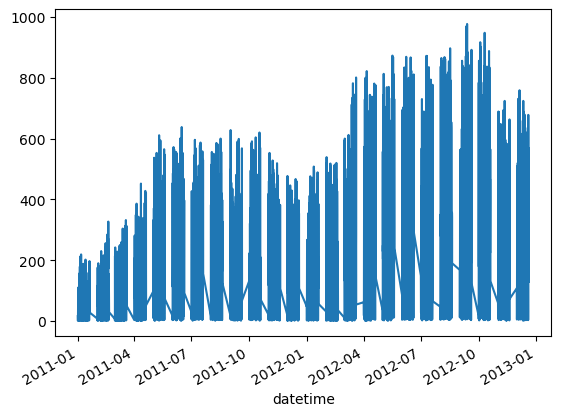

In [17]:
time_span = training_data.copy()
time_span.index = pd.to_datetime(training_data["datetime"])
time_span["count"].plot()

like someone stole chunks of the data, guess for the test data

In [18]:
test_data = pd.read_csv("test_data.csv")

<AxesSubplot:xlabel='datetime'>

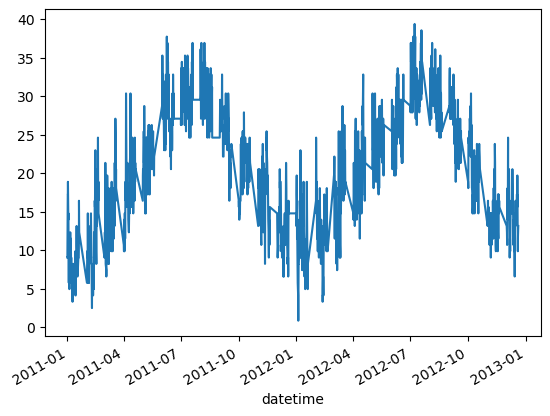

In [19]:
test_time_span = test_data.copy()
test_time_span.index = pd.to_datetime(test_time_span["datetime"])
test_time_span["temp"].plot()

<AxesSubplot:xlabel='datetime'>

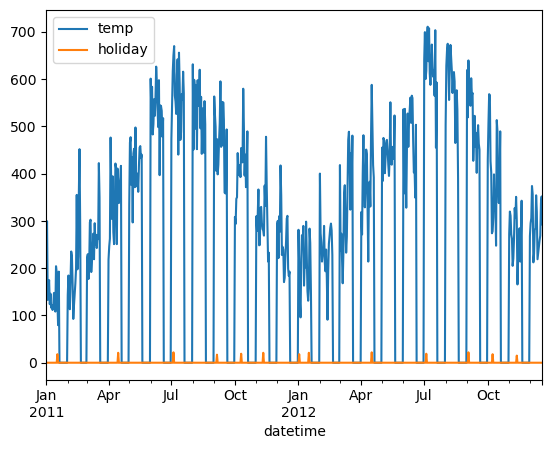

In [20]:
daily = time_span[["temp", "holiday"]].resample("D").sum()
daily.plot()
# daily.tail(25)

<AxesSubplot:xlabel='datetime'>

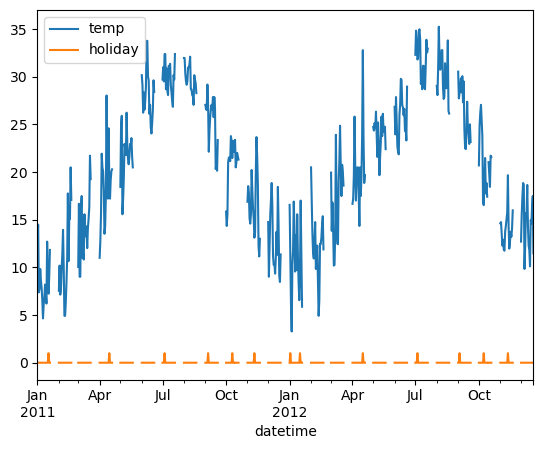

In [21]:
daily = test_time_span[["temp", "holiday"]].resample("D").mean()
daily.plot()

In [22]:
training_data.datetime.min(), training_data.datetime.max(), test_data.datetime.min(), test_data.datetime.max()

('2011-01-01 00:00:00',
 '2012-12-19 22:00:00',
 '2011-01-01 01:00:00',
 '2012-12-19 23:00:00')

In [23]:
test_data.shape

(2178, 10)

Ok this looks like despite being time data it was randomly sampled out maybe weekly. 

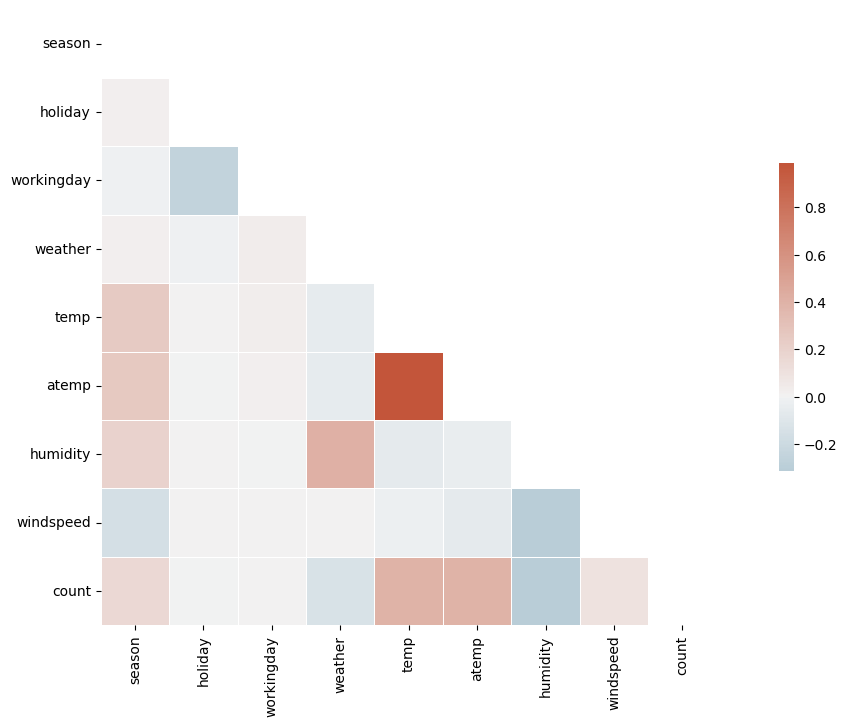

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1.000000,0.023694,-0.006080,0.015364,0.253267,0.260547,0.198741,-0.156544,0.159331
holiday,0.023694,1.000000,-0.254820,-0.010776,0.002996,-0.002293,0.001392,0.003474,-0.005169
workingday,-0.006080,-0.254820,1.000000,0.040086,0.029400,0.024527,-0.003860,0.007291,0.004835
weather,0.015364,-0.010776,0.040086,1.000000,-0.052387,-0.052974,0.412188,0.008978,-0.129810
temp,0.253267,0.002996,0.029400,-0.052387,1.000000,0.985248,-0.062023,-0.026653,0.399809
atemp,0.260547,-0.002293,0.024527,-0.052974,0.985248,1.000000,-0.041475,-0.065143,0.394473
humidity,0.198741,0.001392,-0.003860,0.412188,-0.062023,-0.041475,1.000000,-0.315437,-0.314745
windspeed,-0.156544,0.003474,0.007291,0.008978,-0.026653,-0.065143,-0.315437,1.000000,0.094212
count,0.159331,-0.005169,0.004835,-0.129810,0.399809,0.394473,-0.314745,0.094212,1.000000


In [25]:
correlation_heatmap(training_data.drop(columns=["Unnamed: 0", "casual", "registered"]))

- holiday, working day might be more interesting grouped
- temp is quite strong, but correlates highly with atemp so only choose one
- other notables humidity and wind speed and 
- season seems weak, probably could break it apart to dummies
- weather might be under represented
- seems like hour of the day would be a good variable

some pretty decent looking correlations

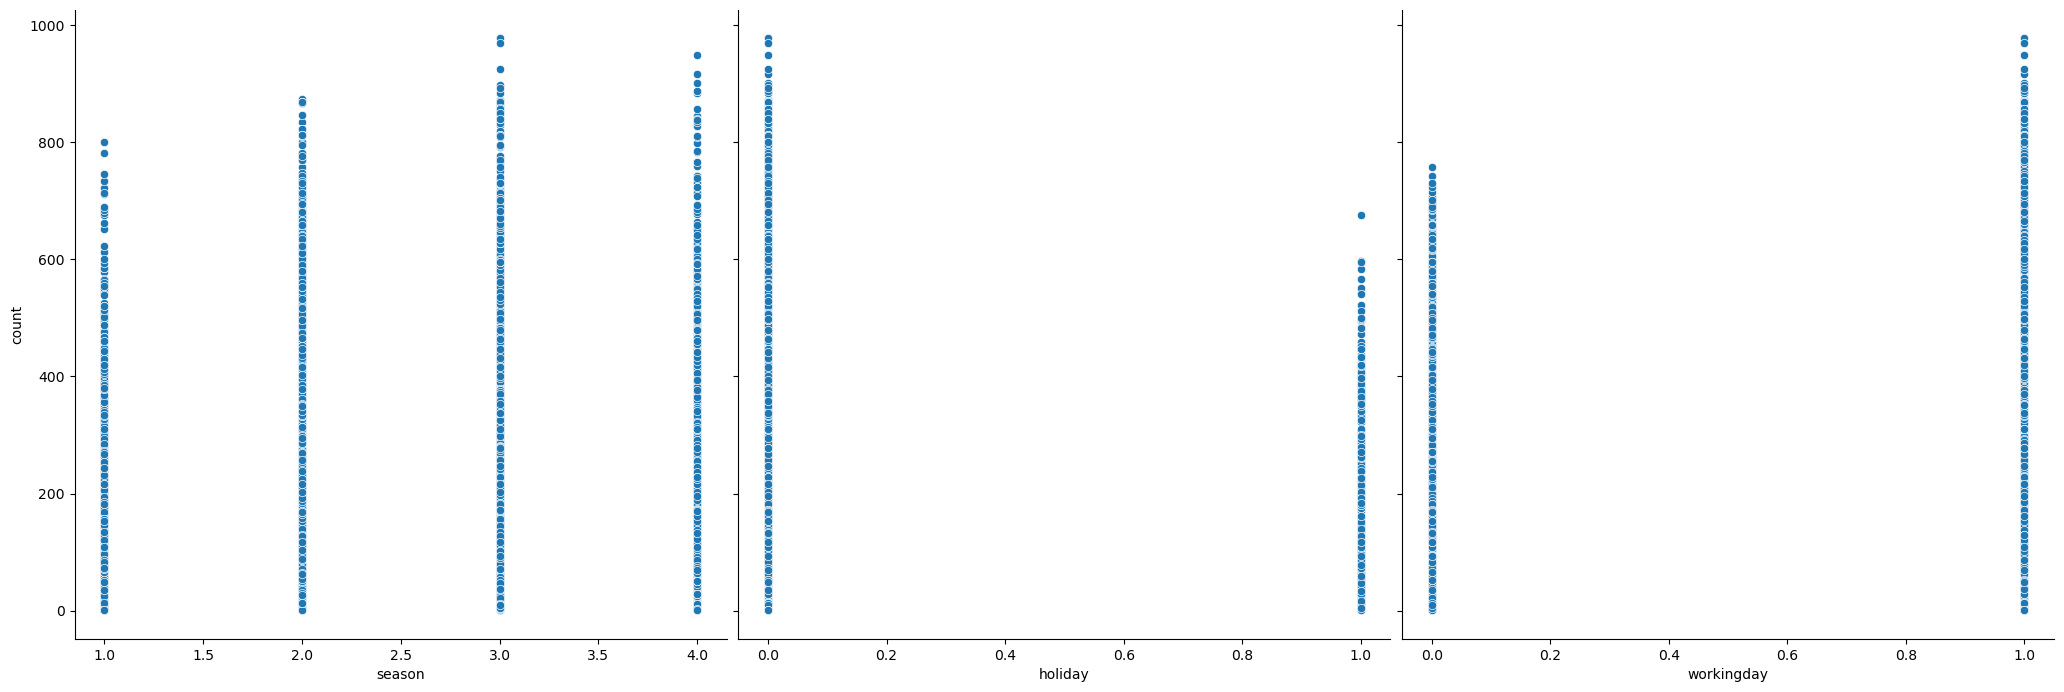

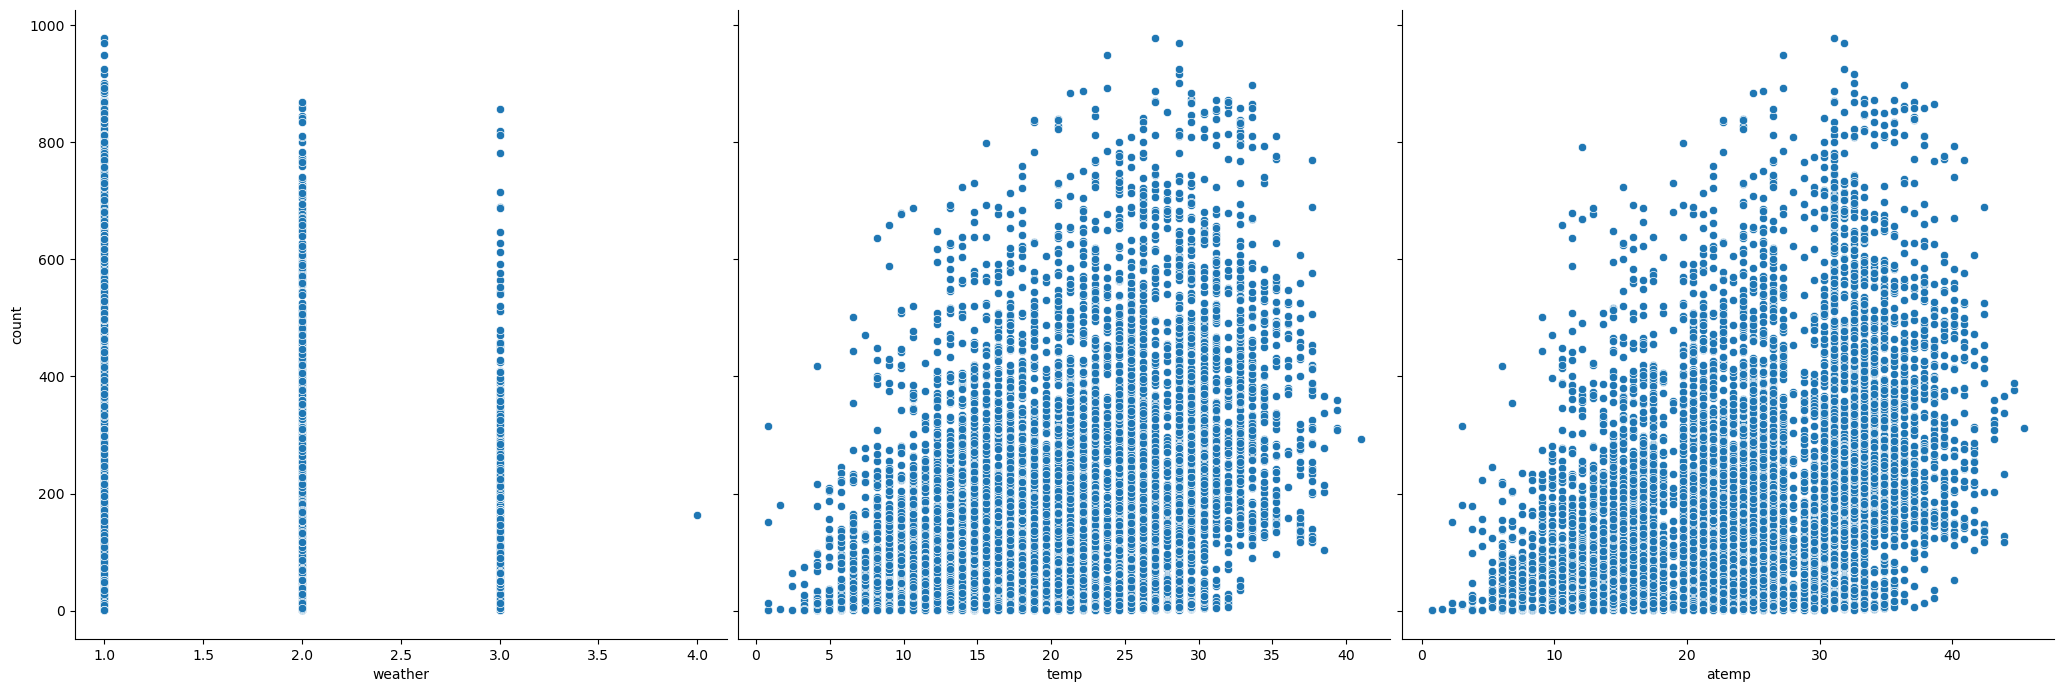

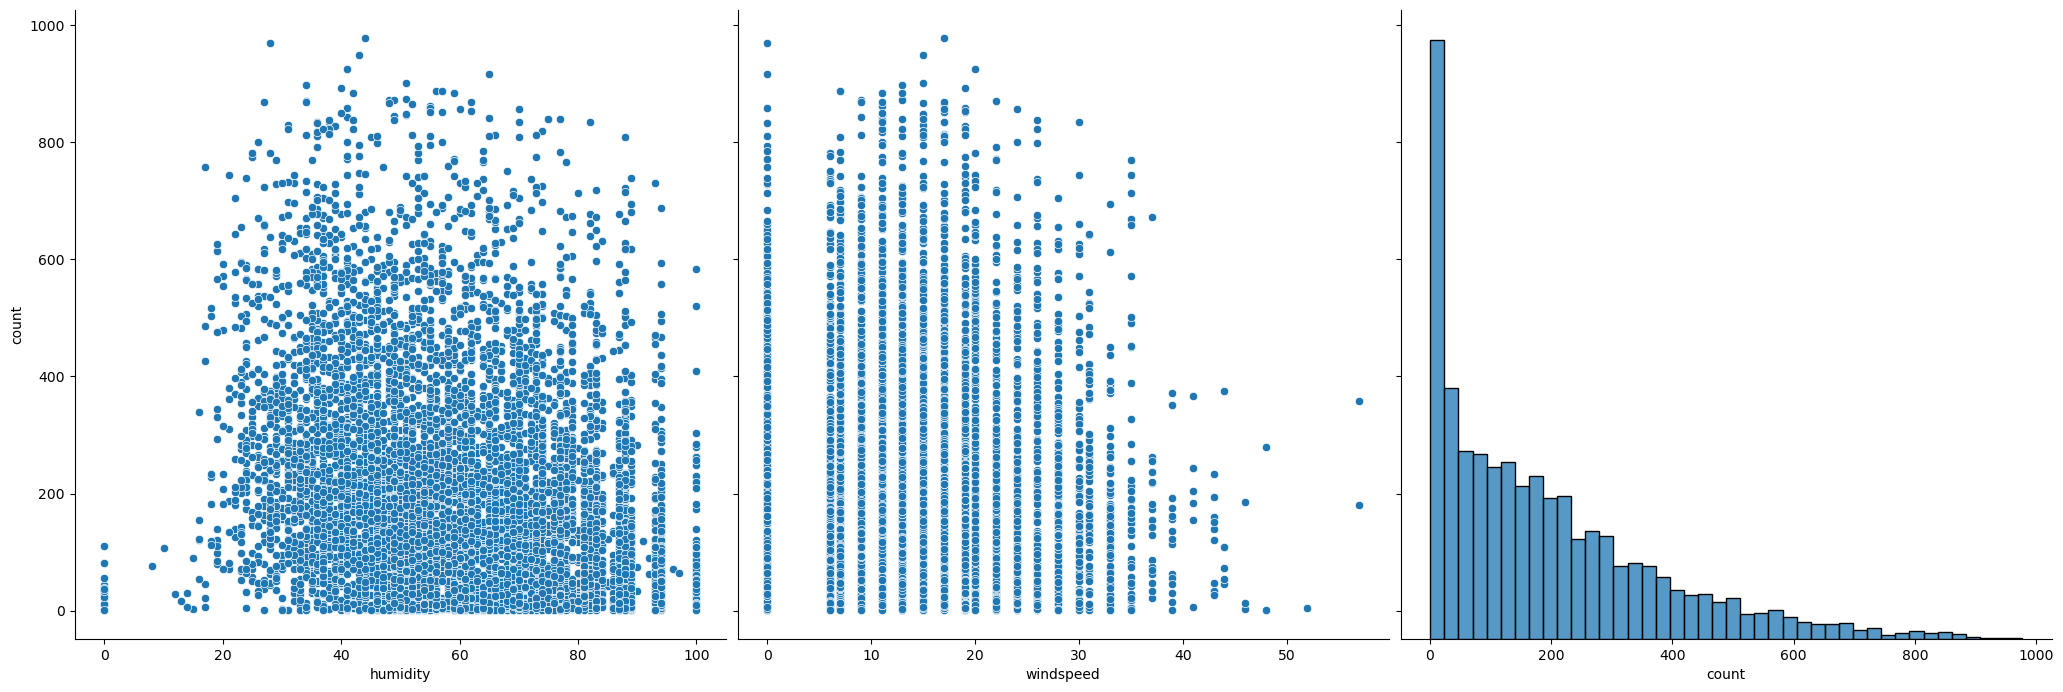

In [26]:

cols = list(training_data.drop(columns=["Unnamed: 0", "casual", "registered", "datetime"]).columns)
# visualize the relationship between the features and the response using scatterplots
for x in range(np.ceil(len(cols) / 3).astype(int)):
    sns.pairplot(training_data, 
             x_vars=cols[x * 3:min((x+1)*3, len(cols))], y_vars='count', height=7, aspect=1)



In [27]:
season_cat = {1: "spring", 2: "summer", 3: "fall", 4: "winter"}
weather_cat = {1: "nice", 2: "modest", 3: "bad", 4: "severe"}
def prepare_data(input_df, drops=[]):
    prep_df_ = input_df.copy().drop(columns=drops)

    # weather - 
    # 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    # 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    # 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    # 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    prep_df_["hour"] = pd.to_datetime(prep_df_["datetime"]).dt.hour

    season_encoded = pd.get_dummies(prep_df_["season"].map(lambda x: season_cat.get(x,"")), prefix="season")
    weather_encoded = pd.get_dummies(prep_df_["weather"].map(lambda x: weather_cat.get(x,"")), prefix="weather")
    # Concatenate the dummies to original dataframe
    prep_df_ = pd.concat([prep_df_, season_encoded, weather_encoded], axis='columns')
    # dropping the original column which was not encoded
    # prep_df = prep_df.drop(['season','weather'], axis='columns')
    return prep_df_
prep_df = prepare_data(training_data, ["Unnamed: 0", "casual", "registered"])
prep_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,season_fall,season_spring,season_summer,season_winter,weather_bad,weather_modest,weather_nice,weather_severe
0,2012-04-19 16:00:00,2,0,1,1,25.42,31.060,41,7.0015,387,16,0,0,1,0,0,0,1,0
1,2012-09-02 10:00:00,3,0,0,2,29.52,34.850,79,0.0000,388,10,1,0,0,0,0,1,0,0
2,2011-12-18 05:00:00,4,0,0,1,8.20,11.365,59,7.0015,5,5,0,0,0,1,0,0,1,0
3,2011-10-07 02:00:00,4,0,1,1,17.22,21.210,88,0.0000,5,2,0,0,0,1,0,0,1,0
4,2011-02-15 16:00:00,1,0,1,1,13.94,15.910,19,16.9979,98,16,0,1,0,0,0,0,1,0


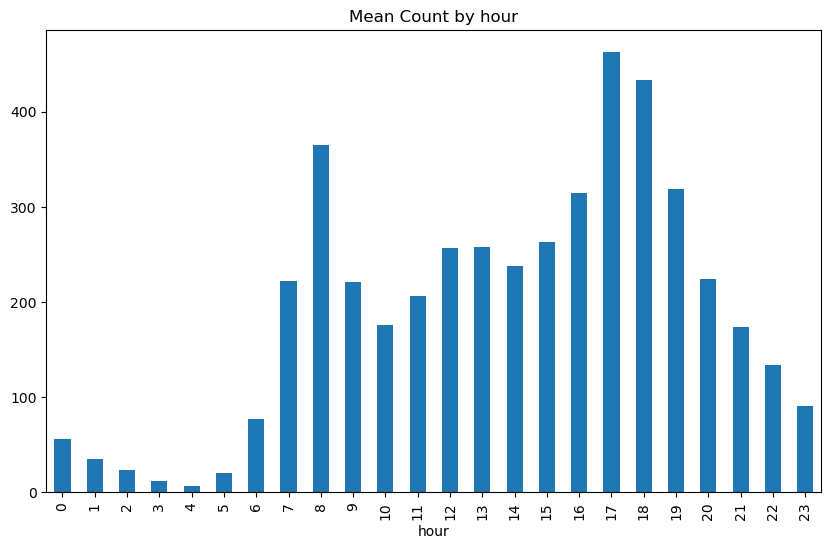

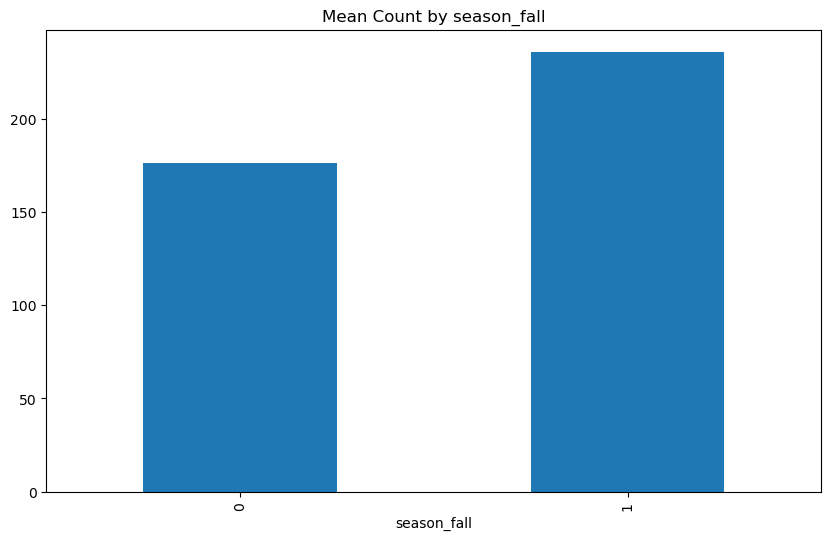

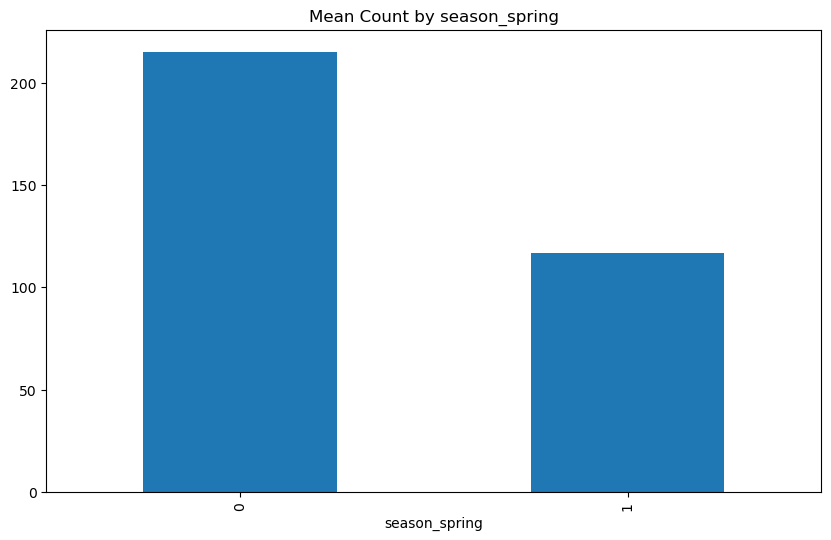

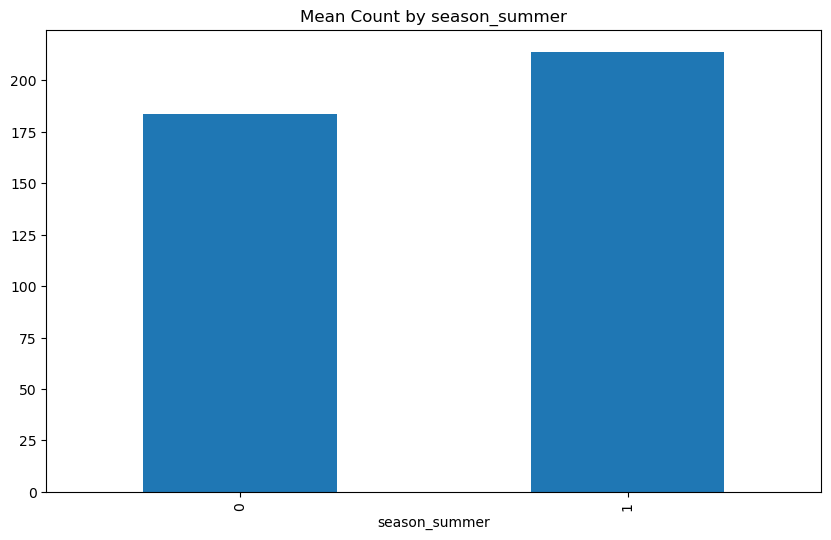

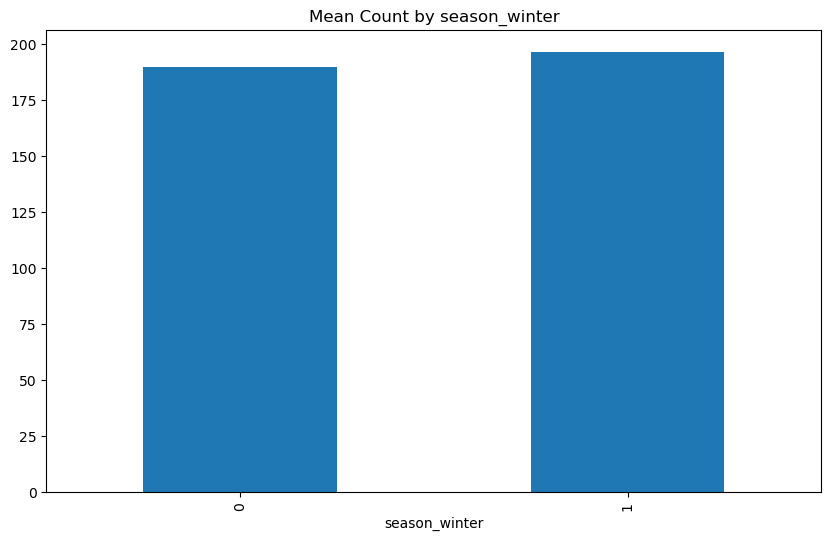

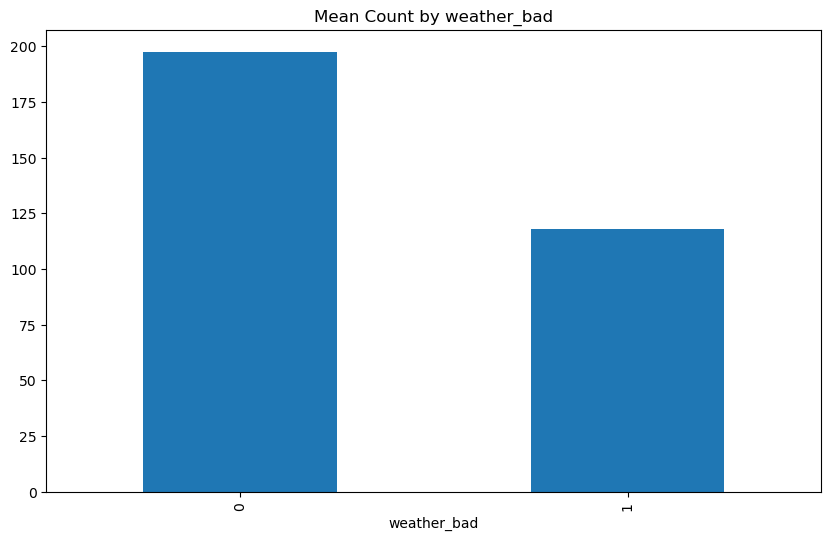

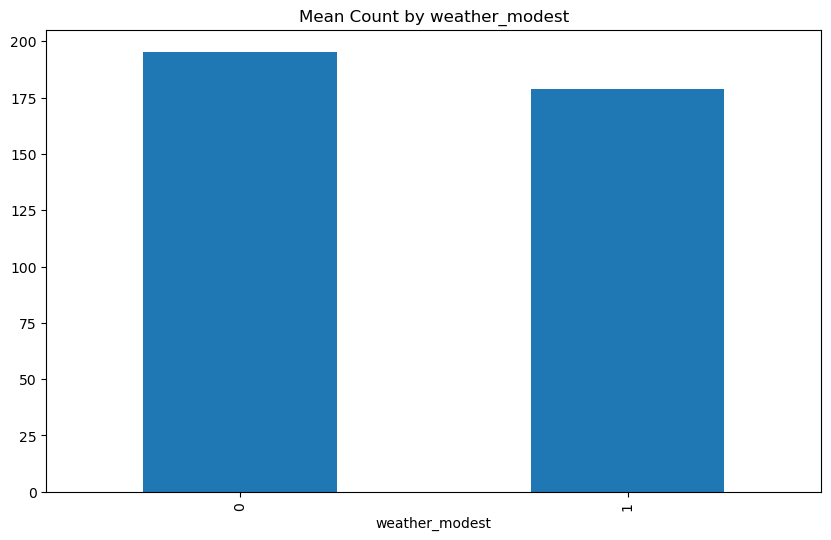

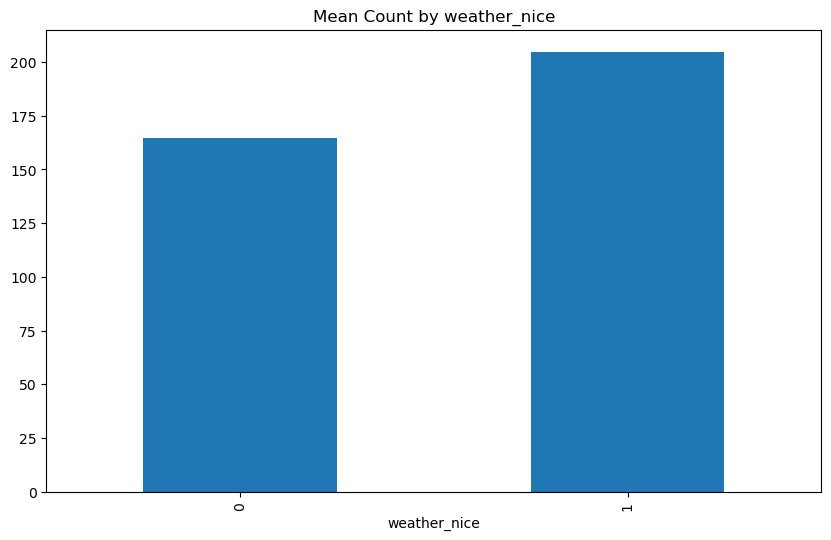

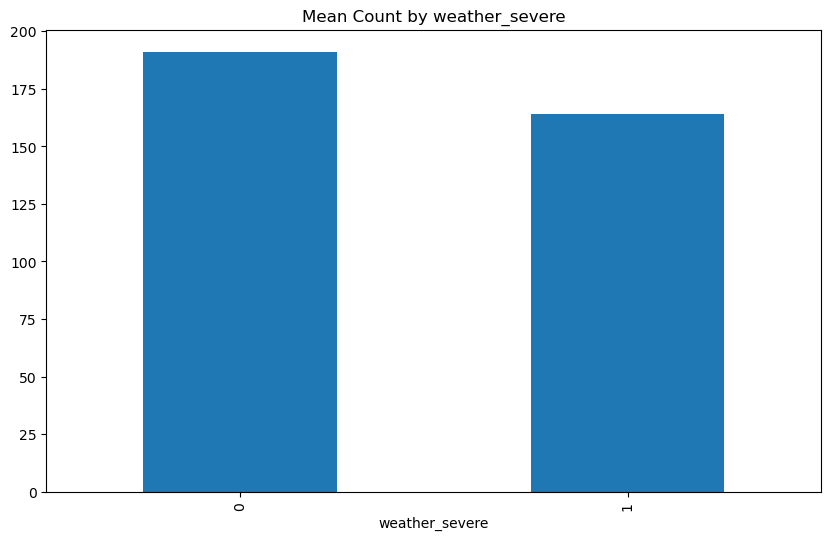

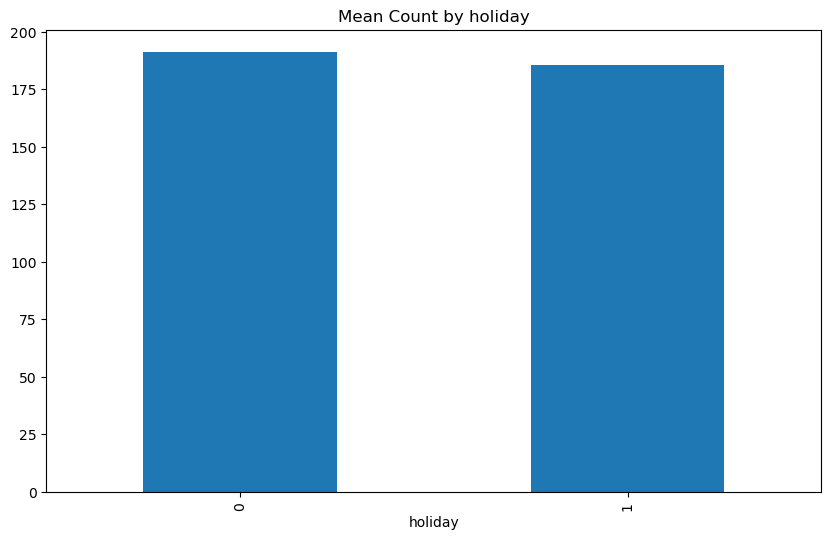

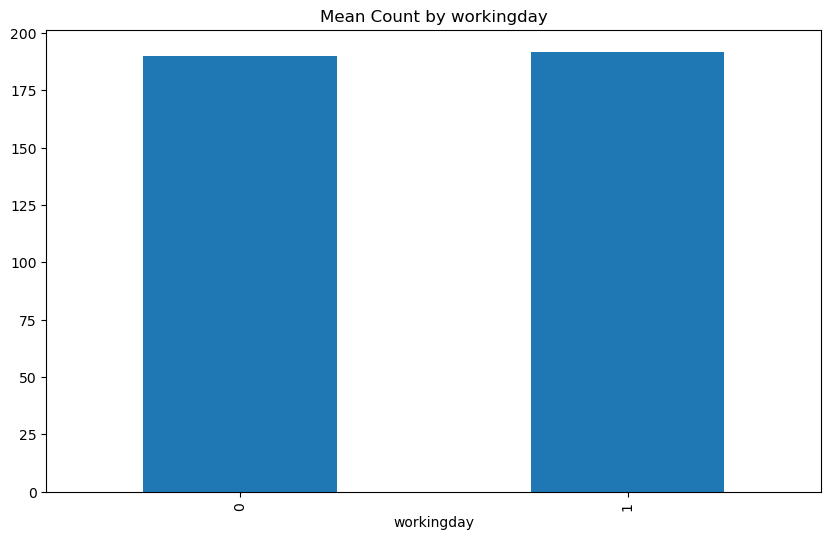

In [28]:
for col in list(prep_df.columns)[-9:] + ["holiday", "workingday"]:
    prep_df.groupby(col)["count"].mean().plot(kind="bar", figsize=[10,6])\
    .set_title(f"Mean Count by {col}")
    plt.show()
    

- Hour looks pretty important
- fall good, spring bad, summer good, winter neutral...
- weather looks pretty ordinal...
- holiday and work day not doing much still

In [29]:
X, y = prep_df.drop(columns=["count", "datetime"]).copy(), training_data["count"].copy()

Build the training and validation

While the training data has a time-series aspect, the training and test seem to be spanning the same time period with sampling so I will do the same for the validation.

In [30]:
random_seed=8675309

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=random_seed
)

confirm everything looks comperable between training and validation

In [32]:
def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

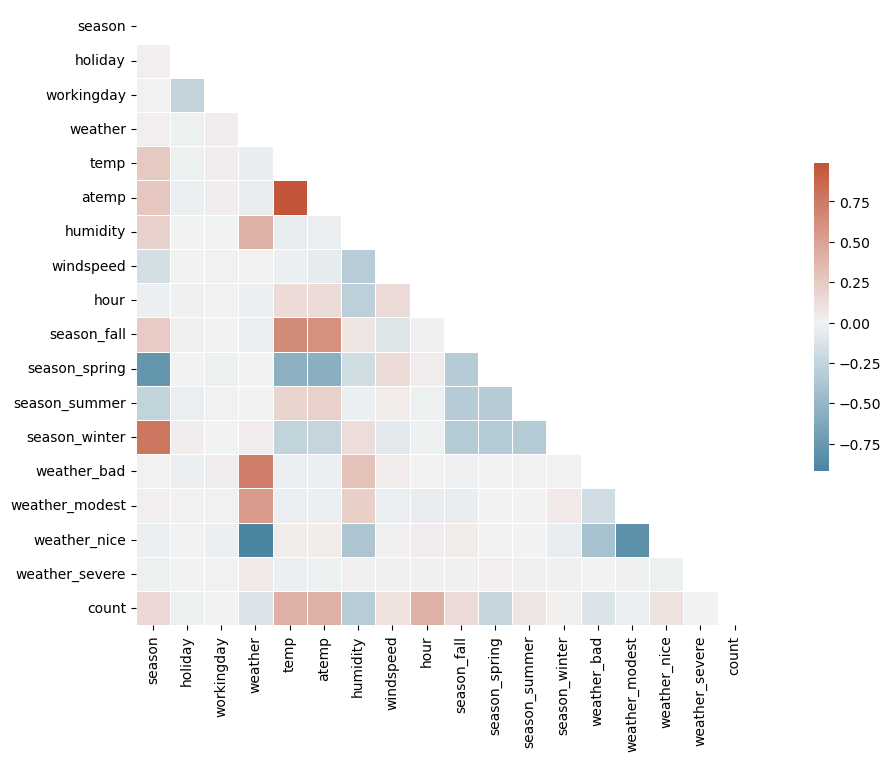

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,season_fall,season_spring,season_summer,season_winter,weather_bad,weather_modest,weather_nice,weather_severe,count
season,1.000000,0.023971,0.006070,0.018471,0.256404,0.264174,0.195798,-0.158742,-0.026999,0.248616,-0.773579,-0.264121,0.778325,0.003545,0.023898,-0.023670,-0.017321,0.158368
holiday,0.023971,1.000000,-0.251448,-0.017430,-0.016293,-0.021395,-0.004060,-0.000882,-0.012126,0.010760,0.000211,-0.036817,0.025535,-0.024355,0.004911,0.009374,-0.002196,-0.016003
workingday,0.006070,-0.251448,1.000000,0.033125,0.033038,0.028110,0.001318,0.006721,0.007713,0.000849,-0.012336,0.010167,0.001282,0.032353,0.007396,-0.025496,0.008733,0.000418
weather,0.018471,-0.017430,0.033125,1.000000,-0.044366,-0.045622,0.410425,0.005505,-0.024531,-0.036600,-0.004595,0.001225,0.039540,0.730560,0.544495,-0.921219,0.052320,-0.126361
temp,0.256404,-0.016293,0.033038,-0.044366,1.000000,0.986334,-0.056351,-0.026874,0.138806,0.636434,-0.559733,0.186729,-0.262065,-0.019905,-0.037997,0.047039,-0.019829,0.406072
atemp,0.264174,-0.021395,0.028110,-0.045622,0.986334,1.000000,-0.036557,-0.061331,0.132669,0.608963,-0.564512,0.197550,-0.240861,-0.025841,-0.032627,0.045412,-0.018567,0.401151
humidity,0.195798,-0.004060,0.001318,0.410425,-0.056351,-0.036557,1.000000,-0.319807,-0.281963,0.073015,-0.176504,-0.026405,0.128001,0.301525,0.221873,-0.377423,0.016111,-0.319498
windspeed,-0.158742,-0.000882,0.006721,0.005505,-0.026874,-0.061331,-0.319807,1.000000,0.149726,-0.099086,0.141970,0.043066,-0.084597,0.035211,-0.034370,0.012073,-0.010879,0.100975
hour,-0.026999,-0.012126,0.007713,-0.024531,0.138806,0.132669,-0.281963,0.149726,1.000000,-0.004785,0.035845,-0.016234,-0.014587,0.008048,-0.046461,0.038102,0.012079,0.405686
season_fall,0.248616,0.010760,0.000849,-0.036600,0.636434,0.608963,0.073015,-0.099086,-0.004785,1.000000,-0.329187,-0.330350,-0.338199,-0.006907,-0.043833,0.044707,-0.007371,0.144945


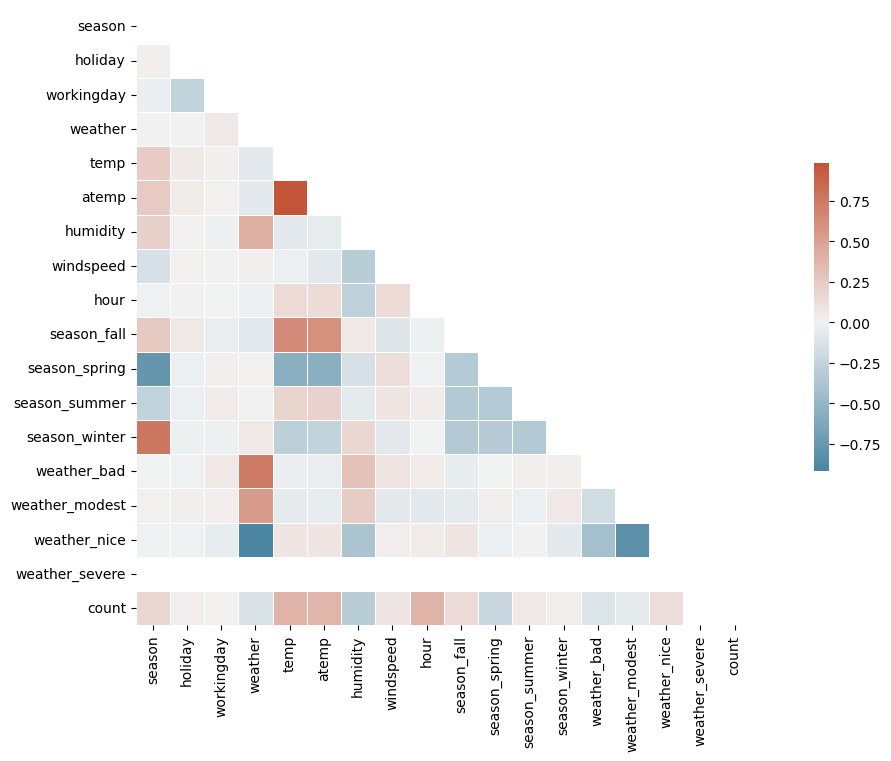

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,season_fall,season_spring,season_summer,season_winter,weather_bad,weather_modest,weather_nice,weather_severe,count
season,1.000000,0.023086,-0.034853,0.008180,0.246014,0.252087,0.205672,-0.151608,-0.006153,0.257458,-0.768952,-0.269788,0.772122,-0.001096,0.013318,-0.011677,NaN,0.161644
holiday,0.023086,1.000000,-0.262725,0.003966,0.046285,0.040802,0.013660,0.013135,0.004594,0.060295,-0.026371,-0.020775,-0.013859,-0.012858,0.021966,-0.012831,NaN,0.019875
workingday,-0.034853,-0.262725,1.000000,0.056003,0.020797,0.016011,-0.015991,0.008673,0.000170,-0.039491,0.017424,0.038533,-0.016150,0.047315,0.022222,-0.048067,NaN,0.015400
weather,0.008180,0.003966,0.056003,1.000000,-0.070941,-0.070078,0.416224,0.016871,-0.015886,-0.077551,0.013895,0.007978,0.056486,0.738807,0.530223,-0.919976,NaN,-0.137940
temp,0.246014,0.046285,0.020797,-0.070941,1.000000,0.982752,-0.075142,-0.026068,0.139918,0.639652,-0.558476,0.189159,-0.283436,-0.034596,-0.060028,0.075626,NaN,0.385204
atemp,0.252087,0.040802,0.016011,-0.070078,0.982752,1.000000,-0.052915,-0.073688,0.135535,0.608564,-0.561674,0.201723,-0.261545,-0.040803,-0.050960,0.070851,NaN,0.378768
humidity,0.205672,0.013660,-0.015991,0.416224,-0.075142,-0.052915,1.000000,-0.305622,-0.278213,0.056736,-0.153283,-0.064564,0.159302,0.294659,0.236858,-0.390390,NaN,-0.303569
windspeed,-0.151608,0.013135,0.008673,0.016871,-0.026068,-0.073688,-0.305622,1.000000,0.140828,-0.103639,0.118159,0.070972,-0.083683,0.081478,-0.077880,0.024619,NaN,0.078662
hour,-0.006153,0.004594,0.000170,-0.015886,0.139918,0.135535,-0.278213,0.140828,1.000000,-0.019135,-0.009470,0.031402,-0.002919,0.039814,-0.073280,0.044599,NaN,0.388456
season_fall,0.257458,0.060295,-0.039491,-0.077551,0.639652,0.608564,0.056736,-0.103639,-0.019135,1.000000,-0.330654,-0.342062,-0.337914,-0.043804,-0.058092,0.079192,NaN,0.140376


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,season_fall,season_spring,season_summer,season_winter,weather_bad,weather_modest,weather_nice,weather_severe,count
count,6095.000000,6095.000000,6095.000000,6095.00000,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000
mean,2.515669,0.028548,0.682691,1.41493,20.195006,23.612253,61.749795,12.869540,11.504512,0.248728,0.246596,0.247908,0.256768,0.078425,0.257588,0.663823,0.000164,191.205578
std,1.121021,0.166546,0.465467,0.63298,7.749558,8.450269,19.283411,8.086046,6.889365,0.432312,0.431065,0.431834,0.436886,0.268861,0.437342,0.472439,0.012809,181.670402
min,1.000000,0.000000,0.000000,1.00000,0.820000,1.515000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.00000,13.940000,16.665000,46.000000,7.001500,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000
50%,3.000000,0.000000,1.000000,1.00000,20.500000,24.240000,61.000000,12.998000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,143.000000
75%,4.000000,0.000000,1.000000,2.00000,26.240000,31.060000,77.000000,19.001200,17.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,283.000000
max,4.000000,1.000000,1.000000,4.00000,39.360000,44.695000,100.000000,56.996900,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,977.000000


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,season_fall,season_spring,season_summer,season_winter,weather_bad,weather_modest,weather_nice,weather_severe,count
count,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.0,2613.000000
mean,2.513203,0.030233,0.688863,1.428626,20.320184,23.741730,61.854956,12.799018,11.526980,0.256028,0.241102,0.253731,0.249139,0.083429,0.261768,0.654803,0.0,190.952162
std,1.109405,0.171262,0.463047,0.641811,7.814850,8.477329,19.385467,8.321787,6.992211,0.436521,0.427834,0.435229,0.432597,0.276583,0.439681,0.475523,0.0,178.362870
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,43.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,148.000000
75%,3.000000,0.000000,1.000000,2.000000,26.240000,31.060000,78.000000,16.997900,17.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.0,281.000000
max,4.000000,1.000000,1.000000,3.000000,41.000000,45.455000,100.000000,56.996900,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,897.000000


In [33]:
train_conf = X_train.copy()
train_conf["count"] = y_train
train_corr = correlation_heatmap(train_conf)
display(train_corr)
val_conf = X_val.copy()
val_conf["count"] = y_val
val_corr = correlation_heatmap(val_conf)
display(val_corr)
display(train_conf.describe())
val_conf.describe()


Lets compare the correlation matrices

In [34]:
stats.kendalltau(upper(train_corr.iloc[:-2,:-2]), upper(val_corr.iloc[:-2,:-2]))

KendalltauResult(correlation=0.8378151260504202, pvalue=6.147274368814223e-42)

thats pretty strong correlation so likely the variable relationships are similar

From above there are a number of features that look pretty decent. I will do a couple runs to compare some feature sets. Also, I will try a few different models to see if it makes a difference.

In [35]:
tight_features = ["temp", "hour", "humidity", "season_spring"] # 
loose_features = tight_features + ["season_fall", "season_summer","weather_bad",
                                   "weather_modest", "weather_nice"]
all_features = X_train.columns.tolist() # 
broad_features = [
    'holiday',
#     'season',
     'workingday',
#      'weather',
     'temp',
     'atemp',
     'humidity',
     'windspeed',
     'hour',
     'season_fall',
     'season_spring',
     'season_summer',
     'season_winter',
     'weather_bad',
     'weather_modest',
     'weather_nice',
#      'weather_severe'
]
ordinal_weather = ['holiday',
                 'workingday',
                 'temp',
                 "weather",
                #  'atemp',
                 'humidity',
                 'windspeed',
                 'hour',
                 'season_fall',
                 'season_spring',
                 'season_summer',
                 'season_winter']
                #  'weather_bad',
                #  'weather_modest',
                #  'weather_nice',
                #  'weather_severe']
all_features

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'hour',
 'season_fall',
 'season_spring',
 'season_summer',
 'season_winter',
 'weather_bad',
 'weather_modest',
 'weather_nice',
 'weather_severe']

In [36]:
def get_models(X, y, features, random_seed_):
    linreg_ = LinearRegression()
    linreg_ = linreg_.fit(X[features], y.values.ravel())
    dtr_ = DecisionTreeRegressor(random_state=random_seed_)
    dtr_ = dtr_.fit(X[features], y.values.ravel())
    rfr_ = RandomForestRegressor(random_state=random_seed_)
    rfr_ = rfr_.fit(X[features], y.values.ravel())
    return linreg_, dtr_, rfr_

In [37]:
t_linreg, t_dtr, t_rfr = get_models(X_train, y_train, tight_features, random_seed)
l_linreg, l_dtr, l_rfr = get_models(X_train, y_train, loose_features, random_seed)
a_linreg, a_dtr, a_rfr = get_models(X_train, y_train, broad_features, random_seed)
o_linreg, o_dtr, o_rfr = get_models(X_train, y_train, ordinal_weather, random_seed)

In [38]:
def results(model, y, X, model_name, batch):
    pred = model.predict(X)
    pd.DataFrame(zip(pred, y), columns=["pred", "actual"]).tail(200).plot().set_title(model_name)

    # Capping the negative values at 0 because they do not make sense
    pred[pred < 0] = 0
    rslts = dict(batch=batch, 
                 model=model_name,
                 msle = mean_squared_log_error(y, pred),
                 r2_s = r2_score(y, pred),
                 rmsle = np.sqrt(mean_squared_log_error(y, pred)),
                 mae = mean_absolute_error(y, pred),
                 rmse = np.sqrt(mean_squared_error(y, pred)),
                 mape = mean_absolute_percentage_error(y, pred),
                 y_mean = np.mean(y),
                 pred_mean = np.mean(pred),
                )
            
#     print(model_name)
    return(rslts)




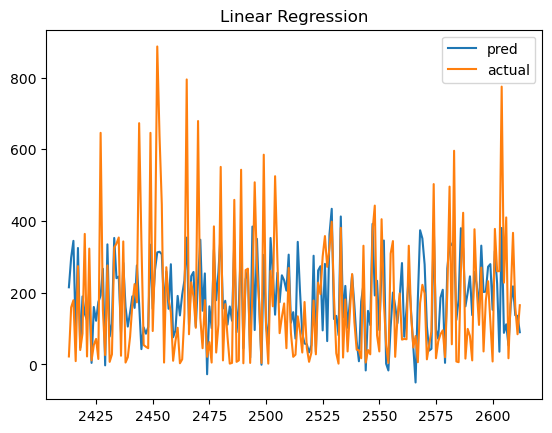

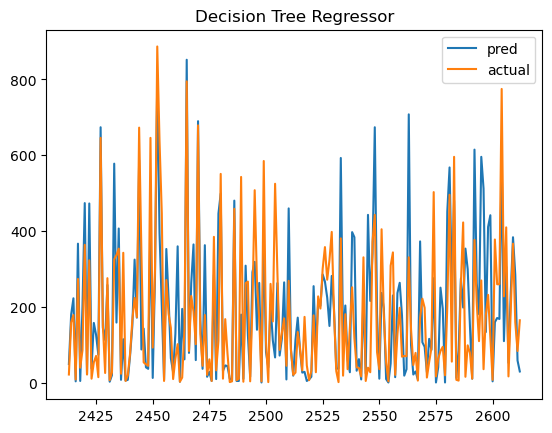

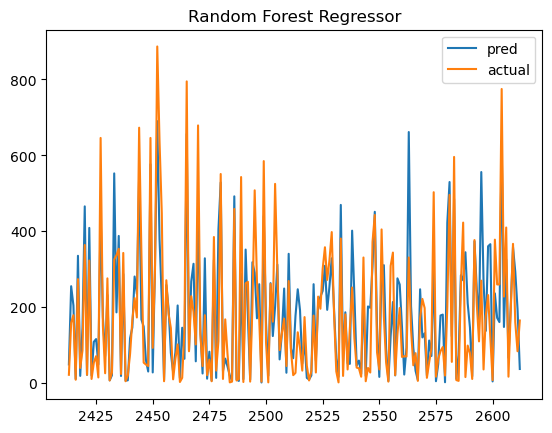

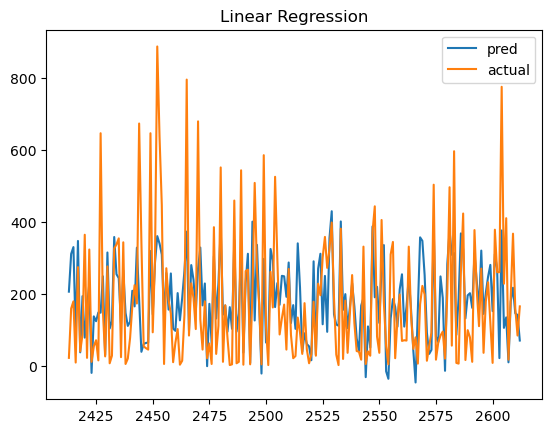

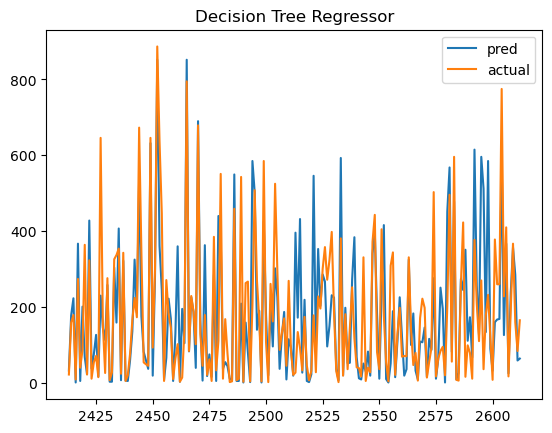

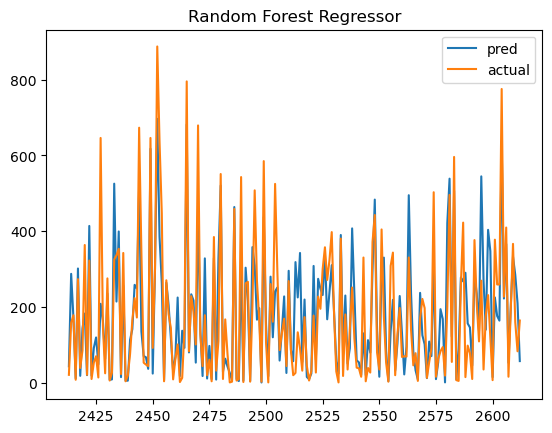

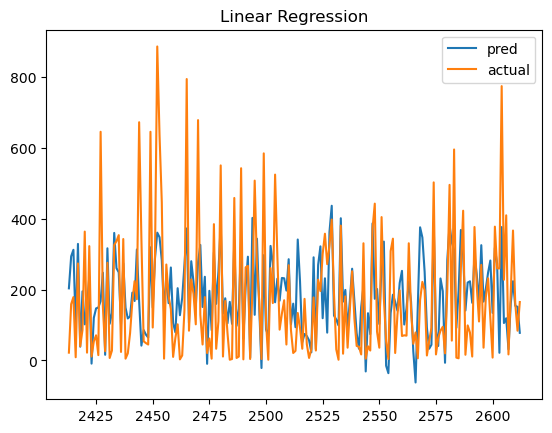

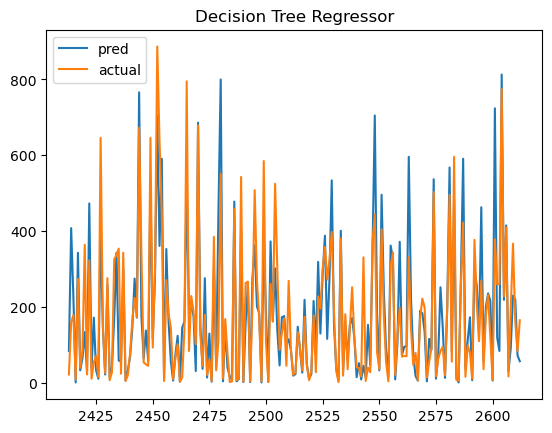

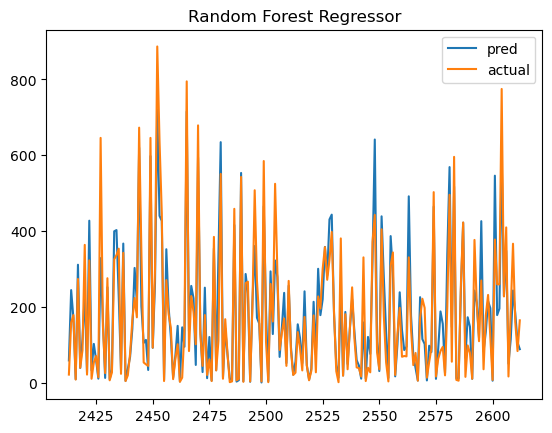

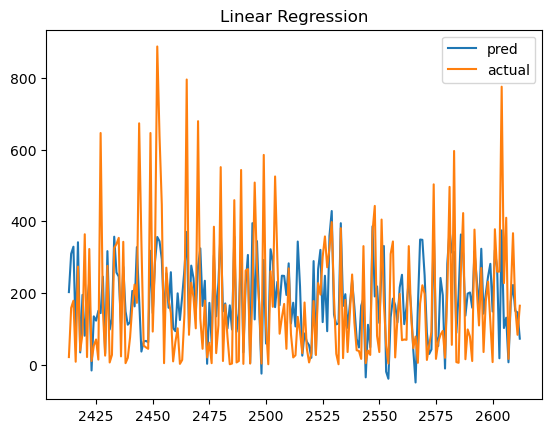

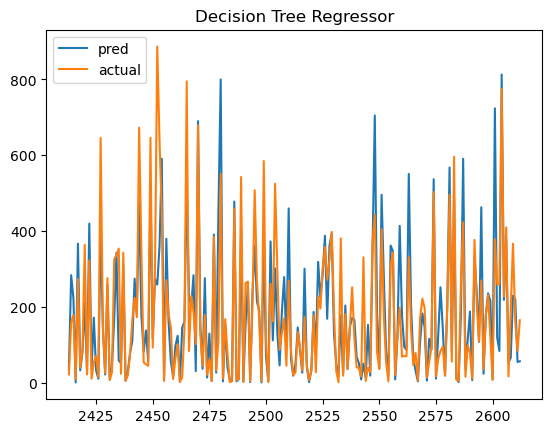

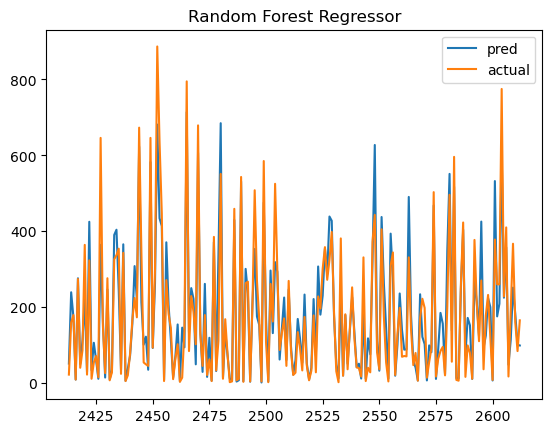

In [65]:
# print("Tight Features")
performance = []
for model_, name in [[t_linreg, "Linear Regression"],
                     [t_dtr, "Decision Tree Regressor"],
                     [t_rfr, "Random Forest Regressor"]]:
    performance.append(results(model_, y_val, X_val[tight_features], name, "Tight Features"))
    
# print("Loose Features")
for model_, name in [[l_linreg, "Linear Regression"],
                     [l_dtr, "Decision Tree Regressor"],
                     [l_rfr, "Random Forest Regressor"]]:
    performance.append(results(model_, y_val, X_val[loose_features], name, "Loose Features"))

for model_, name in [[o_linreg, "Linear Regression"],
                     [o_dtr, "Decision Tree Regressor"],
                     [o_rfr, "Random Forest Regressor"]]:
    performance.append(results(model_, y_val, X_val[ordinal_weather], name, "Ordinal Weather"))
for model_, name in [[a_linreg, "Linear Regression"],
                     [a_dtr, "Decision Tree Regressor"],
                     [a_rfr, "Random Forest Regressor"]]:
    performance.append(results(model_, y_val, X_val[broad_features], name, "Broad Features"))


In [66]:
pd.DataFrame(performance).sort_values("rmsle")

,batch,model,msle,r2_s,rmsle,mae,rmse,mape,y_mean,pred_mean
11,Broad Features,Random Forest Regressor,0.190137,0.843132,0.436047,47.070851,70.629942,0.444890,190.952162,193.460346
8,Ordinal Weather,Random Forest Regressor,0.191747,0.842193,0.437890,46.951683,70.841003,0.447067,190.952162,193.438940
7,Ordinal Weather,Decision Tree Regressor,0.330495,0.690665,0.574887,62.270570,99.182626,0.545728,190.952162,194.331037
10,Broad Features,Decision Tree Regressor,0.330729,0.687914,0.575090,62.690586,99.622786,0.541027,190.952162,194.482013
5,Loose Features,Random Forest Regressor,0.471902,0.652414,0.686951,69.707349,105.136175,0.901461,190.952162,194.031246
2,Tight Features,Random Forest Regressor,0.508299,0.608365,0.712951,74.463935,111.599506,0.933799,190.952162,194.109458
4,Loose Features,Decision Tree Regressor,0.718948,0.422164,0.847908,86.597525,135.557509,0.973732,190.952162,194.224518
1,Tight Features,Decision Tree Regressor,0.752087,0.399722,0.867229,90.061271,138.164891,1.061999,190.952162,197.781464
9,Broad Features,Linear Regression,1.609178,0.327762,1.268534,106.786916,146.211985,2.753307,190.952162,193.022240
3,Loose Features,Linear Regression,1.610374,0.328470,1.269005,106.854864,146.134928,2.767848,190.952162,193.097731


Winning model and feature set:

In [67]:
print("Winning model and feature set: Random Forest, Broad Features")
pd.DataFrame(zip(broad_features,a_rfr.feature_importances_),
             columns=["feature", "importance"]).sort_values("importance", ascending=False).round(4)


Winning model and feature set: Random Forest, Broad Features


,feature,importance
6,hour,0.5885
2,temp,0.1205
1,workingday,0.0719
4,humidity,0.0697
3,atemp,0.0470
5,windspeed,0.0350
8,season_spring,0.0189
11,weather_bad,0.0166
10,season_winter,0.0121
13,weather_nice,0.0050


Despite the correlation working day really ends up being very important, also atemp seems to have some additonal juice despire the high correlation with temp.

Looks like a nice bump with the additonal features, overall not too bad. The clear winner is the Random Forest Regressor which is not surprising. Lets apply it!

In [68]:
test_data.columns

Index(['Unnamed: 0', 'datetime', 'season', 'holiday', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [69]:
test_df = prepare_data(test_data, ["Unnamed: 0"])

quick correlation check that relationships are similar

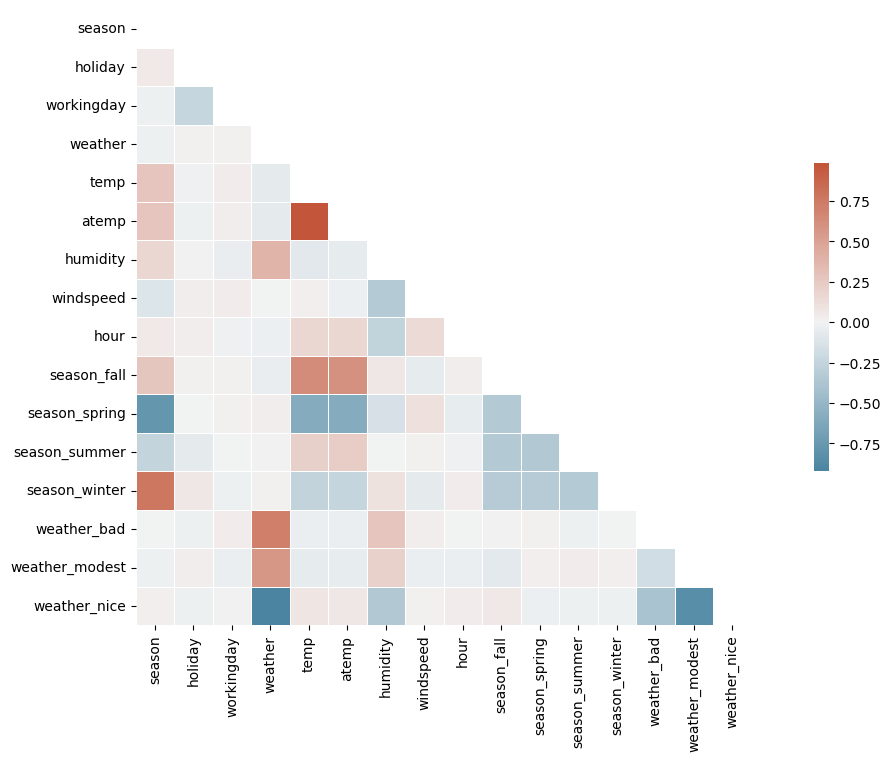

In [70]:
test_corr = correlation_heatmap(test_df)

In [71]:
test_corr

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,season_fall,season_spring,season_summer,season_winter,weather_bad,weather_modest,weather_nice
season,1.000000,0.052769,-0.017416,-0.017735,0.280346,0.281713,0.158298,-0.110405,0.051344,0.275019,-0.774120,-0.250521,0.768077,-0.004965,-0.019229,0.020684
holiday,0.052769,1.000000,-0.233675,0.008526,-0.010824,-0.017262,0.004543,0.028555,0.027512,0.009245,-0.004759,-0.064547,0.061661,-0.014530,0.029385,-0.019333
workingday,-0.017416,-0.233675,1.000000,0.008416,0.032146,0.025270,-0.038198,0.036318,-0.007058,0.008792,0.012499,-0.000914,-0.020800,0.034812,-0.029517,0.008199
weather,-0.017735,0.008526,0.008416,1.000000,-0.065647,-0.065029,0.381934,0.000216,-0.026204,-0.040452,0.023509,0.007496,0.009506,0.719005,0.561525,-0.922606
temp,0.280346,-0.010824,0.032146,-0.065647,1.000000,0.983789,-0.076715,0.016653,0.170314,0.630284,-0.590249,0.212841,-0.257350,-0.031251,-0.055851,0.069419
atemp,0.281713,-0.017262,0.025270,-0.065029,0.983789,1.000000,-0.051922,-0.027197,0.167338,0.600107,-0.590378,0.226287,-0.240256,-0.034356,-0.051279,0.066879
humidity,0.158298,0.004543,-0.038198,0.381934,-0.076715,-0.051922,1.000000,-0.331072,-0.267214,0.064100,-0.153333,-0.003849,0.095367,0.281724,0.205998,-0.348427
windspeed,-0.110405,0.028555,0.036318,0.000216,0.016653,-0.027197,-0.331072,1.000000,0.145912,-0.055750,0.106168,0.009327,-0.061281,0.028686,-0.033847,0.015636
hour,0.051344,0.027512,-0.007058,-0.026204,0.170314,0.167338,-0.267214,0.145912,1.000000,0.023573,-0.046741,-0.007103,0.031044,-0.001535,-0.035318,0.033781
season_fall,0.275019,0.009245,0.008792,-0.040452,0.630284,0.600107,0.064100,-0.055750,0.023573,1.000000,-0.338246,-0.340705,-0.323897,0.007994,-0.066861,0.057902


In [72]:
train_corr.iloc[:-2, :-2]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,season_fall,season_spring,season_summer,season_winter,weather_bad,weather_modest,weather_nice
season,1.000000,0.023971,0.006070,0.018471,0.256404,0.264174,0.195798,-0.158742,-0.026999,0.248616,-0.773579,-0.264121,0.778325,0.003545,0.023898,-0.023670
holiday,0.023971,1.000000,-0.251448,-0.017430,-0.016293,-0.021395,-0.004060,-0.000882,-0.012126,0.010760,0.000211,-0.036817,0.025535,-0.024355,0.004911,0.009374
workingday,0.006070,-0.251448,1.000000,0.033125,0.033038,0.028110,0.001318,0.006721,0.007713,0.000849,-0.012336,0.010167,0.001282,0.032353,0.007396,-0.025496
weather,0.018471,-0.017430,0.033125,1.000000,-0.044366,-0.045622,0.410425,0.005505,-0.024531,-0.036600,-0.004595,0.001225,0.039540,0.730560,0.544495,-0.921219
temp,0.256404,-0.016293,0.033038,-0.044366,1.000000,0.986334,-0.056351,-0.026874,0.138806,0.636434,-0.559733,0.186729,-0.262065,-0.019905,-0.037997,0.047039
atemp,0.264174,-0.021395,0.028110,-0.045622,0.986334,1.000000,-0.036557,-0.061331,0.132669,0.608963,-0.564512,0.197550,-0.240861,-0.025841,-0.032627,0.045412
humidity,0.195798,-0.004060,0.001318,0.410425,-0.056351,-0.036557,1.000000,-0.319807,-0.281963,0.073015,-0.176504,-0.026405,0.128001,0.301525,0.221873,-0.377423
windspeed,-0.158742,-0.000882,0.006721,0.005505,-0.026874,-0.061331,-0.319807,1.000000,0.149726,-0.099086,0.141970,0.043066,-0.084597,0.035211,-0.034370,0.012073
hour,-0.026999,-0.012126,0.007713,-0.024531,0.138806,0.132669,-0.281963,0.149726,1.000000,-0.004785,0.035845,-0.016234,-0.014587,0.008048,-0.046461,0.038102
season_fall,0.248616,0.010760,0.000849,-0.036600,0.636434,0.608963,0.073015,-0.099086,-0.004785,1.000000,-0.329187,-0.330350,-0.338199,-0.006907,-0.043833,0.044707


In [73]:
stats.spearmanr(upper(test_corr), upper(train_corr.iloc[:-2, :-2]))

SpearmanrResult(correlation=0.8893534273213416, pvalue=6.45464365917625e-42)

so far so good

In [74]:
test_pred = a_rfr.predict(test_df[broad_features])

In [75]:
display(pd.Series(test_pred).describe())
display(training_data["count"].describe())

count    2178.000000
mean      193.994339
std       168.916138
min         1.460000
25%        52.942500
50%       156.680000
75%       283.980000
max       809.780000
dtype: float64

count    8708.000000
mean      191.129536
std       180.674085
min         1.000000
25%        42.000000
50%       145.000000
75%       283.000000
max       977.000000
Name: count, dtype: float64

In [76]:
test_df['count'] = test_pred

In [77]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,season_fall,season_spring,season_summer,season_winter,weather_bad,weather_modest,weather_nice,count
0,2012-03-17 02:00:00,1,0,0,2,18.04,21.970,88,0.0000,2,0,1,0,0,0,1,0,49.70
1,2012-03-04 11:00:00,1,0,0,1,13.12,14.395,45,26.0027,11,0,1,0,0,0,0,1,168.77
2,2011-10-10 02:00:00,4,1,0,1,19.68,23.485,88,0.0000,2,0,0,0,1,0,0,1,36.20
3,2012-03-09 16:00:00,1,0,1,1,19.68,23.485,23,27.9993,16,0,1,0,0,0,0,1,232.42
4,2012-06-04 10:00:00,2,0,1,1,26.24,31.060,41,31.0009,10,0,0,1,0,0,0,1,205.59


In [78]:
predicted_test_data = pd.merge(test_data, test_df[["datetime", "count"]], on="datetime")

In [79]:
predicted_test_data.head()

,Unnamed: 0,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,6715,2012-03-17 02:00:00,1,0,0,2,18.04,21.970,88,0.0000,49.70
1,6413,2012-03-04 11:00:00,1,0,0,1,13.12,14.395,45,26.0027,168.77
2,4273,2011-10-10 02:00:00,4,1,0,1,19.68,23.485,88,0.0000,36.20
3,6538,2012-03-09 16:00:00,1,0,1,1,19.68,23.485,23,27.9993,232.42
4,7777,2012-06-04 10:00:00,2,0,1,1,26.24,31.060,41,31.0009,205.59


In [80]:
predicted_test_data.drop(columns="Unnamed: 0").to_csv("predicted_test_data.csv", index=False)